# Выбор локации для скважины

В исходных данных представлены пробы нефти из трех регионов, в каждом из которых 100000 месторождений, где измерили качество нефти и объем ее запасов. 

**Цель:** Необходимо определить место для бурения новой скважины.

**Задачи:**
- определить значения признаков для каждого месторождения;
- построить и обучить модель для оценки объема запасов месторождения;
- выбрать месторождения с самыми высокими оценками значений;
- проанализировать возможную прибыль и риски техникой *Bootstrap*.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
- `/datasets/geo_data_0.csv.`
- `/datasets/geo_data_1.csv.` 
- `/datasets/geo_data_2.csv.`
<br>

- `id` - уникальный идентификатор скважины;
- `f1`, `f2`, `f3` - три "обезличенных" признака;
- `product` - объем запасов в скважине (тыс. бареллей)

## Загрузка и подготовка данных

In [1]:
# импортируем все необходимые библиотеки
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from pprint import pprint

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution

In [2]:
# задаем стили и размер графиков
sns.set(style='darkgrid', rc={'figure.figsize': (9, 6)})

In [3]:
%%html
<style>
    .conclusion {
        background: #F9F5E7;
        padding: 2% 2%;
        color: #A7727D;
        border: 0.1rem solid;
        border-radius: 4px;
        border-color: darkgray;
    }
    .conclusion span{
        background: #F0EEED;
        color: black;
        padding: 1px 3px;
    }
</style>

In [4]:
# меняем путь до директории с файлами
os.chdir('../../YandexPracticum/datasets/')

In [5]:
# загружаем данные, для удобства все данные сохраним в один DataFrame,
# а для указания региона заведем дополнительную колонку region

geo_df = pd.DataFrame()

for region in range(3):
    geo_region_df = pd.read_csv(f'geo_data_{region}.csv')
    
    # попутно выведем также число записей в датасете
    print(f'Число записей для {region} датасета: {geo_region_df.shape[0]}')
    
    geo_region_df['region'] = region
    geo_df = pd.concat([geo_df, geo_region_df])
    
# зададим колонку region в качестве категориальной
geo_df.region = geo_df.region.astype('category')

Число записей для 0 датасета: 100000
Число записей для 1 датасета: 100000
Число записей для 2 датасета: 100000


In [6]:
# создадим функцию для ознакомления с датасетом

def check_dataset(data: pd.DataFrame) -> None:
    
    # выводим 5 случайных строк из датасета
    display(data.sample(5))
    
    # выводим основную информацию по датасету
    data.info(memory_usage='deep')
    
    # считаем число пропусков в каждой колонке
    display(data.isna().sum().to_frame(name='num of NaNs'))
    
    print('Число полностью дублирующихся строк:', data.duplicated().sum())

In [7]:
check_dataset(geo_df)

,id,f0,f1,f2,product,region
60256,HsFGL,0.992790,0.173745,4.895294,92.116438,0
10673,0tbLd,0.638375,2.993190,1.320591,90.591796,2
12144,XdD5Y,3.360577,0.970703,3.998390,107.813044,1
49062,oZCEK,-0.329313,-5.391427,-2.006523,174.056641,2
58738,3YtJU,2.021236,1.682902,5.275568,121.826815,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   id       300000 non-null  object  
 1   f0       300000 non-null  float64 
 2   f1       300000 non-null  float64 
 3   f2       300000 non-null  float64 
 4   product  300000 non-null  float64 
 5   region   300000 non-null  category
dtypes: category(1), float64(4), object(1)
memory usage: 29.5 MB


,num of NaNs
id,0
f0,0
f1,0
f2,0
product,0
region,0


Число полностью дублирующихся строк: 0


In [8]:
# посмотрим, дублируются ли идентификаторы
geo_df.id.duplicated().sum()

49

In [9]:
# найдено 49 дубликатов, посмотрим, относятся ли они к разным регионам
geo_df[geo_df.id.duplicated(keep=False)].sort_values(['id', 'region']).head(10)

,id,f0,f1,f2,product,region
45429,2tyMi,0.576679,-0.411140,-3.725859,69.292672,0
27380,2tyMi,-1.789602,-1.359044,-4.840745,145.901447,2
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625,1
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044,1
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029,0
72896,5ssQt,-0.651825,0.782415,2.690636,120.108761,2
64022,74z30,0.741456,0.459229,5.153109,140.771492,0
66136,74z30,1.084962,-0.312358,6.990771,127.643327,0
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364,0
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205,0


Интересно, что в рамках даже одного региона встречаются дубликаты идентификаторов, но значения всех остальных признаков разные. Странно, но ничего плохого, по идее, в этом нет.

<div class='conclusion'>
    <b>Итог:</b> в каждом загруженном датасете имеется 100000 записей, нет пропусков и полностью дублирующихся строк.
<div>

In [10]:
# поскольку номер id не имеет никакой закономерности и не поможет при обучении моделей, удалим эту колонку из датасета
geo_df = geo_df.drop('id', axis=1)

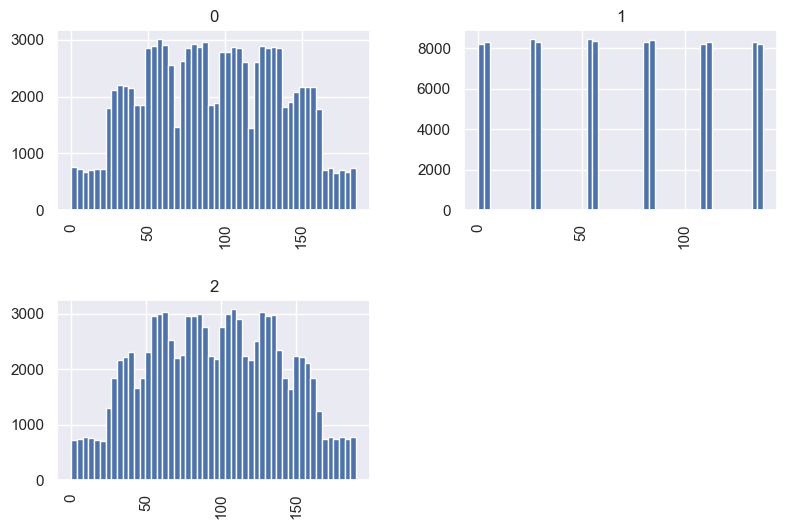

In [11]:
# построим гистограммы распределений целевого признака для разных регионов
geo_df.hist('product', by='region', bins=50);

Построим зависимости признаков друг от друга. Не будем использовать scatter_matrix, поскольку в данном случае получается сложно интерпретируемая мешанина. Признаков совсем немного, поэтому сделаем все построения *step-by-step*.

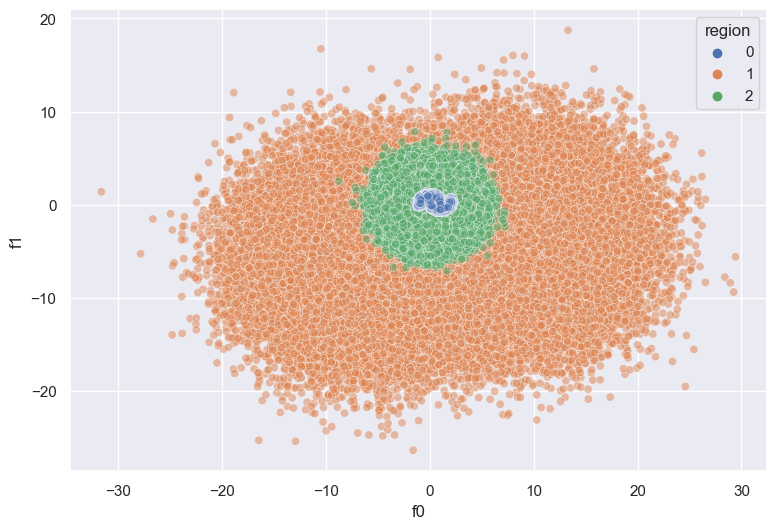

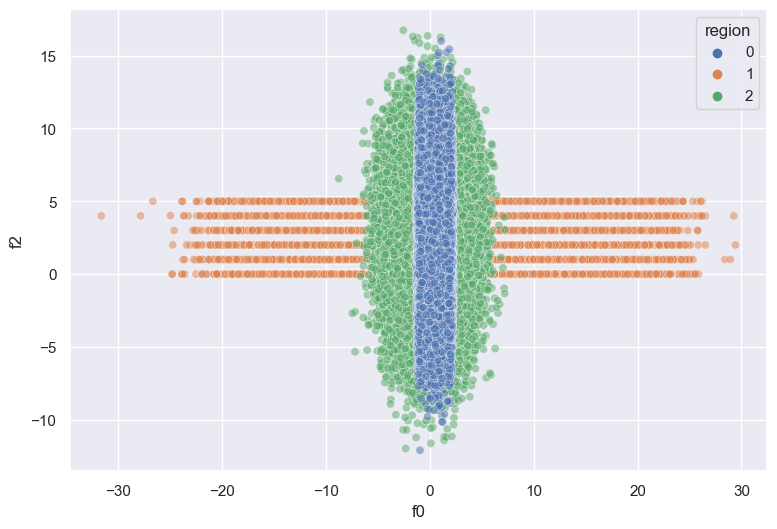

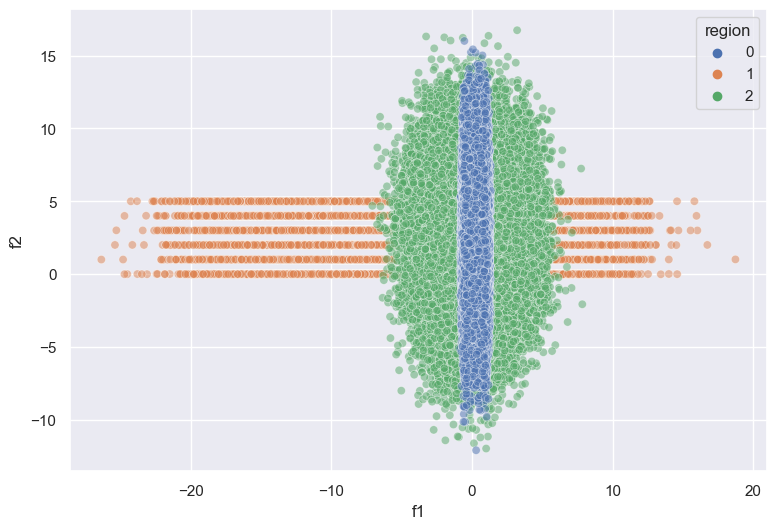

In [12]:
# построим зависимости f0, f1 и f2 друг от друга
# чтобы на графике f1(f0) было видно все распределения, необходимо отсортировать датафрейм по регионам 1 -> 2 -> 0
df = pd.concat([geo_df.loc[geo_df.region.isin([1, 2])].sort_values('region', ascending=True), 
                geo_df.query('region == 0')])

for x, y in combinations(['f0', 'f1', 'f2'], 2):
    sns.scatterplot(df, x=x, y=y, alpha=0.5, hue='region')
    plt.show()

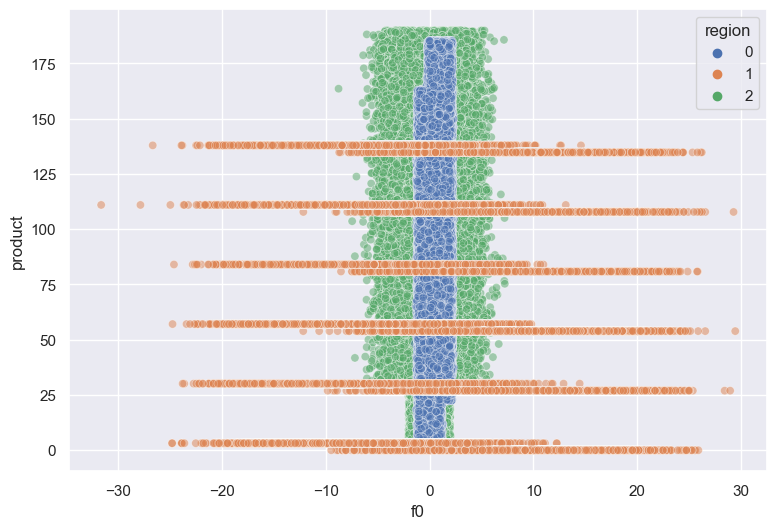

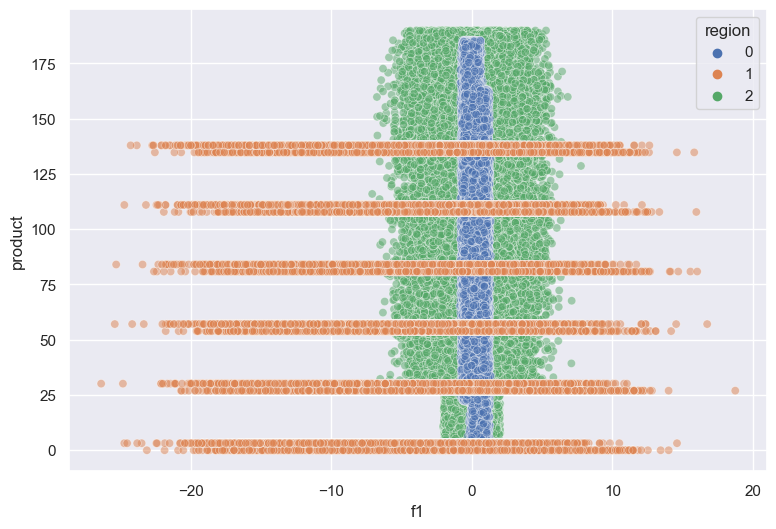

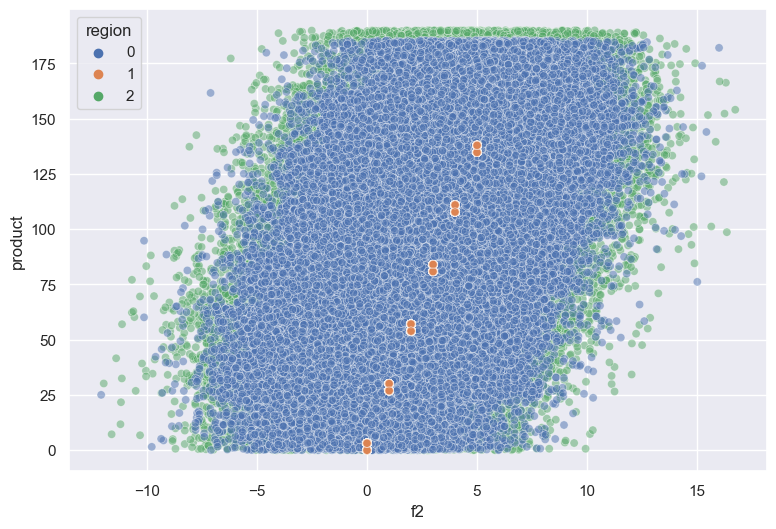

In [13]:
# построим зависимости product от f0, f1, f2
# теперь для корректного отображения порядок должен быть 2 -> 0 -> 1
df = pd.concat([geo_df.loc[geo_df.region.isin([2, 0])].sort_values('region', ascending=False), 
                geo_df.query('region == 1')])

for n in range(3):
    sns.scatterplot(df, x=f'f{n}', y='product', alpha=0.5, hue='region', style_order=[2, 0, 1])
    plt.show()

In [14]:
# оценим линейную связь параметров
for n in range(3):
    print(f'Матрица корреляции для региона {n}')
    display(geo_df.query(f'region == @n').corr(numeric_only=True).style.background_gradient())

Матрица корреляции для региона 0


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Матрица корреляции для региона 1


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Матрица корреляции для региона 2


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


<div class='conclusion'>
Целевая переменная имеет сложное осциллирующее распределение для всех регионов. В случае региона 1 оно близко к дискретному.

Признаки и целевая переменная зависят друг от друга сложным образом, причем для каждого региона зависимости отличаются значительно:
- f1(f0): зависимости для регионов 1 и 2 схожи, но различаются по масштабам: зависимость для региона 1 имеет больший разброс по обеим осям и смещена по f1 в сторону отрицальных значений. Для региона 0 зависимость имеет сложную форму в виде двух инвертированных и смещенных друг относительно друга полудуг. Для данных зависимостей коэффициенты корреляции Пирсона неприменимы;
- f2(f1) и f2(f0): значения для регионов 0 и 2 распределены вблизи 0 по f0 и f1 и смещены в сторону положительных значений по f2. Для региона 2 распределение имеет более широкий разброс значений по f0 и f1. В случае региона 1 значения f2 принимают значения, близкие к целым числам от 0 до 5. Распределение по f1 смещено в сторону отрицательных значений.
- product(f0) и product(f1): зависимости схожи с предыдущими, только распределены на другом масштабе.
- product(f2): наблюдается средняя корреляция для регионов 0 и 2, и сильная для региона 1.
</div>

## Обучение и проверка модели

### Разбиение данных

In [15]:
# в списках будем хранить датафреймы для каждого региона
# индекс датафрейма в списке будет соответствовать номеру региона
geos_train = []
geos_valid = []

for n in range(3):
    df = geo_df.query('region == @n').drop(['region'], axis=1)
    df_train, df_valid = train_test_split(df, test_size=0.25)
    
    geos_train.append(df_train)
    geos_valid.append(df_valid)

In [16]:
# проверим один из датафремов
geos_train[0].head()

,f0,f1,f2,product
96287,0.078206,1.026910,3.170747,80.379539
15192,2.163023,0.438728,-3.486890,45.525255
18932,0.637582,-0.526340,6.145058,162.561952
17006,-0.060022,1.034043,-0.789534,29.907282
79635,1.235548,-0.500100,4.707245,135.115743


### Обучение моделей: Регион 0

Для поиска оптимальных гиперпараметров будем использовать `OptunaSearchCV`. Добавим к ней немного функциональности: она будет хранить данные для обучения и валидации; после фита сразу будут выводиться лучшие гиперпараметры, показатели RMSE и строиться график зависимости целевой переменной на тренировочных данных (предсказанный и истинный). При создании экземпляра оптюне будет передаваться дефолтный пайплайн. Также модель, после обучения и задания необходимых параметров может использоваться для проведения бутстрепа.

In [17]:
class LinearModel(OptunaSearchCV):
    # в переменных класса будем хранить значения переменных, необходимых для бутстрепа
    budget = None
    unit_revenue = None
    n_wells_exploration = None
    n_wells_development = None
    
    # вводим один раз, и переменные будут доступны для всех экземпляров
    @classmethod
    def set_bootstrap_params(cls, budget, unit_revenue, n_wells_exploration, n_wells_development):
        cls.budget = budget
        cls.unit_revenue = unit_revenue
        cls.n_wells_exploration = n_wells_exploration
        cls.n_wells_development = n_wells_development
    
    def __init__(self, param_distributions, df_train, df_valid):
        super().__init__(
            Pipeline([
                        ('scaler', StandardScaler()), 
                        ('func', FunctionTransformer()),
                        ('poly', PolynomialFeatures()),
                        ('regressor', Ridge())
                    ]), 
            param_distributions
        )
        
        self.random_state=42
        self.n_jobs = -1
        self.scoring = 'neg_mean_squared_error'
        self.refit = True
        
        self.X_train = df_train.drop('product', axis=1)
        self.X_valid = df_valid.drop('product', axis=1)
        self.y_train = df_train['product']
        self.y_valid = df_valid['product']
        
        self.prediction = None
    
    def fit(self) -> None:
        super().fit(self.X_train, self.y_train)
        
        # сюда сохраняем результаты предсказаний
        self.prediction = self.best_estimator_.predict(self.X_valid)
        
        print('Лучшие значения параметров:')
        pprint(self.best_params_)
        print(f'\nRMSE (best train): {np.sqrt(-self.best_score_)}')
        print('RMSE (valid):', mean_squared_error(self.y_valid, self.prediction, squared=False))
        
        # строим получившиеся значения в виде зависимости predicted(true)
        plt.Figure()
        
        plt.plot(self.y_valid, self.prediction, 'o', label=f'Predicted', alpha=0.6, markersize=4)
        plt.plot(self.y_valid, self.y_valid, 'ro', label=f'True', alpha=0.6, markersize=4)
        
        pred_mean = self.prediction.mean()
        valid_mean = self.y_valid.mean()
        plt.plot(pred_mean, pred_mean, 'o', markersize=14, alpha=0.7, label=f'Mean (pred): {pred_mean:.2f}')
        plt.plot(valid_mean, valid_mean, 'o', markersize=8, alpha=0.9, label=f'Mean (true): {valid_mean:.2f}')
        
        plt.legend()
        plt.title('Product')
        plt.xlabel('True value')
        plt.ylabel('Predictred value')
        
        plt.show()
        
    def __ready_for_bootstrap(self):
        # проверяем, что все значения введены, модель обучена 
        class_vars = [self.budget, self.unit_revenue, self.n_wells_exploration, self.n_wells_development]
        assert all(var is not None for var in class_vars), 'Не заданы параметры для проведения бутстрепа.'\
                                                           ' Используйте self.set_bootstrap_params()'
        assert self.prediction is not None, 'Модель не была обучена и валидирована, исправьте сиё недоразумение'
        assert self.n_wells_exploration >= self.n_wells_development, 'Число скважин для разведки меньше,'\
                                                            ' чем скважин для разработки'
    
    # метод для проведения бутстрепа
    def bootstrap(self, n_iterations=1000) -> pd.Series:
        self.__ready_for_bootstrap()
        
        # объединяем предикт и валидационные данные для удобного сэмплирования
        data = pd.DataFrame({'predict': self.prediction, 'true': self.y_valid})
        state = np.random.RandomState(101)
        
        # сюда будем сохранять значения прибыли
        values = pd.Series(index=range(n_iterations), dtype='float64')
        
        for i in range(n_iterations):
            subsample = data.sample(self.n_wells_exploration, replace=True, random_state=state)
            subsample = subsample.sort_values('predict', ascending=False)[:self.n_wells_development]
            values[i] = subsample.true.sum() * self.unit_revenue - self.budget
        

        
        print(f"Средняя прибыль: {values.mean():,.0f}")
        print(f"2.5%-квантиль:   {values.quantile(0.025):,.0f}")
        print(f"97.5%-квантиль:  {values.quantile(0.975):,.0f}")
        
        ax = sns.histplot(x=values)

        ax.axvline(x=values.quantile(0.025), ymax=0.25, linestyle='dashed', color='red', linewidth=2)
        ax.axvline(x=values.mean(), ymax=0.5, linestyle='dashed', color='red', linewidth=2)
        ax.axvline(x=values.quantile(0.975), ymax=0.25, linestyle='dashed', color='red', linewidth=2)

        ax.text(.4, .2, s=f'mean: {values.mean():,.0f}', backgroundcolor='white', transform=ax.transAxes)
        ax.text(values.quantile(0.025), y=5, s=f'Q (2.5%)', backgroundcolor='white')
        ax.text(values.quantile(0.975), y=5, s=f'Q (97.5%)', backgroundcolor='white')

        plt.show()
        
        return values

In [18]:
# зададим диапазоны гиперпараметров, по которым будет проводиться поиск оптимальных значений
grid = {
        'func__func': CategoricalDistribution([None, np.tanh, np.arctan]),
        'poly__degree': IntDistribution(1, 10), 
        'regressor__alpha': FloatDistribution(0.01, 10, log=True),
       }

D:\Programs\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <ufunc 'tanh'> which is of type ufunc.
  warnings.warn(message)
D:\Programs\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <ufunc 'arctan'> which is of type ufunc.
  warnings.warn(message)


C:\Users\Sergei\AppData\Local\Temp\ipykernel_17140\1036216221.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  super().__init__(
[I 2023-05-18 15:52:21,198] A new study created in memory with name: no-name-64dd6354-d0ce-4ede-ab53-04f0fed5fe53
[I 2023-05-18 15:52:21,816] Trial 2 finished with value: -1421.908409816335 and parameters: {'func__func': <ufunc 'arctan'>, 'poly__degree': 1, 'regressor__alpha': 4.738021156366034}. Best is trial 2 with value: -1421.908409816335.
[I 2023-05-18 15:52:21,978] Trial 3 finished with value: -1422.0147224129882 and parameters: {'func__func': <ufunc 'arctan'>, 'poly__degree': 2, 'regressor__alpha': 4.352758214084702}. Best is trial 2 with value: -1421.908409816335.
[I 2023-05-18 15:52:22,151] Trial 4 finished with value: -1384.6181597040854 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 3, 'regressor__alpha': 0.06127731404892886}. Best is trial 4 with value: -

Лучшие значения параметров:
{'func__func': None, 'poly__degree': 7, 'regressor__alpha': 0.05368013963107098}

RMSE (best train): 37.091239979355436
RMSE (valid): 37.097205740120295


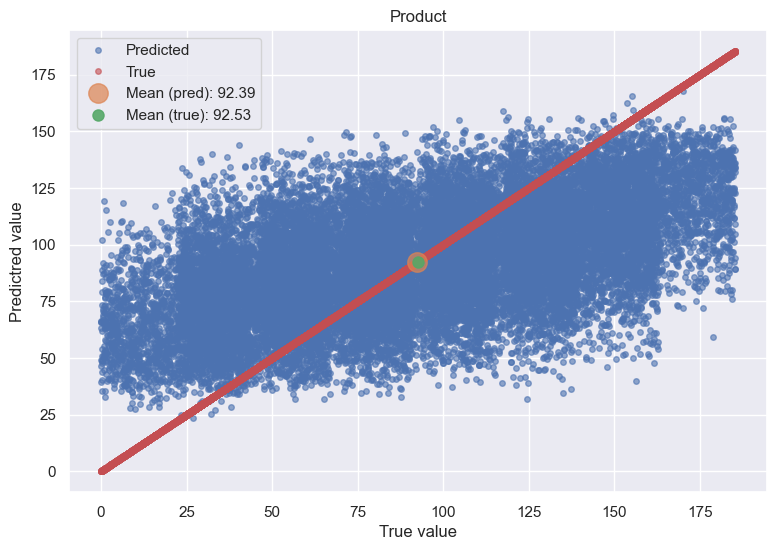

In [19]:
reg0_model = LinearModel(
    grid,
    geos_train[0], geos_valid[0]
)

reg0_model.fit()

### Обучение моделей: Регион 1

C:\Users\Sergei\AppData\Local\Temp\ipykernel_17140\1036216221.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  super().__init__(
[I 2023-05-18 15:52:24,899] A new study created in memory with name: no-name-caa3f4c7-f26a-4b9a-bea0-beec2ec6f12d
[I 2023-05-18 15:52:25,403] Trial 6 finished with value: -0.7920266480167205 and parameters: {'func__func': None, 'poly__degree': 1, 'regressor__alpha': 0.15794630683898925}. Best is trial 6 with value: -0.7920266480167205.
[I 2023-05-18 15:52:25,465] Trial 2 finished with value: -44.13249612843366 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 1, 'regressor__alpha': 0.012290966265031006}. Best is trial 6 with value: -0.7920266480167205.
[I 2023-05-18 15:52:25,626] Trial 1 finished with value: -44.132504838787554 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 1, 'regressor__alpha': 1.4337766721706768}. Best is trial 6 with value: -0.792026

Лучшие значения параметров:
{'func__func': <ufunc 'tanh'>,
 'poly__degree': 8,
 'regressor__alpha': 1.8223200581057073}

RMSE (best train): 0.7165103243402315
RMSE (valid): 0.7182229688025483


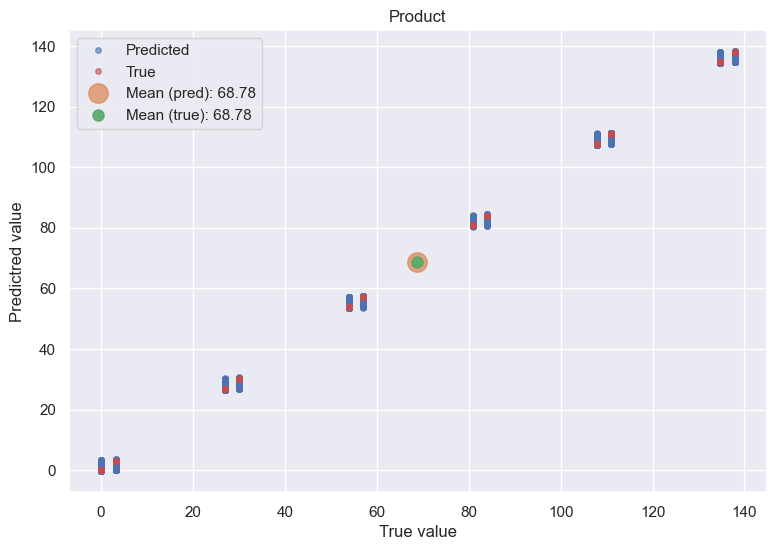

In [20]:
reg1_model = LinearModel(
    grid, 
    geos_train[1], geos_valid[1]
)

reg1_model.fit()

### Обучение моделей: Регион 2

C:\Users\Sergei\AppData\Local\Temp\ipykernel_17140\1036216221.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  super().__init__(
[I 2023-05-18 15:52:28,487] A new study created in memory with name: no-name-ca988941-6c2e-4a9e-942c-af8d547293dc
[I 2023-05-18 15:52:28,993] Trial 9 finished with value: -1607.5115156864044 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 1, 'regressor__alpha': 2.5704114438328904}. Best is trial 9 with value: -1607.5115156864044.
[I 2023-05-18 15:52:29,116] Trial 7 finished with value: -1470.4439043820355 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 2, 'regressor__alpha': 7.555305034244686}. Best is trial 7 with value: -1470.4439043820355.
[I 2023-05-18 15:52:29,646] Trial 3 finished with value: -1445.0916273372172 and parameters: {'func__func': <ufunc 'tanh'>, 'poly__degree': 4, 'regressor__alpha': 0.05809786621493284}. Best is trial 3 with value: -

Лучшие значения параметров:
{'func__func': <ufunc 'tanh'>,
 'poly__degree': 10,
 'regressor__alpha': 1.0189335409076732}

RMSE (best train): 37.72294929770389
RMSE (valid): 37.79767141645194


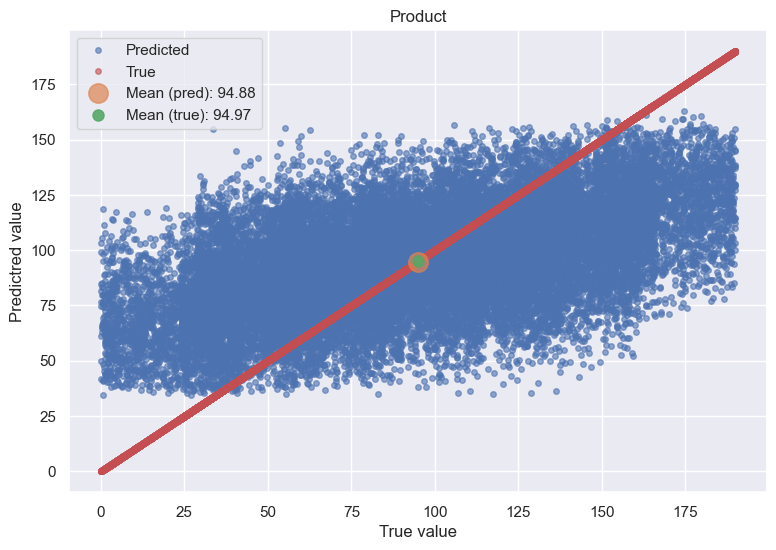

In [21]:
reg2_model = LinearModel(
    grid, 
    geos_train[2], geos_valid[2]
)

reg2_model.fit()

<div class='conclusion'>
Как видно, линейные модели достаточно плохо справляются с предсказаниями для случая регионов 0 и 2. RMSE в данных случаях больше 37 тыс. баррелей. В случае региона 1 линейная модель показывает себя гораздо лучше, среднеквадратичный разброс значений составляет всего около 0.7 тыс. баррелей.
    
Для улучшения линейных моделей необходимо овладение методикой feature engineering.
</div>

## Подготовка к расчёту прибыли

In [22]:
BUDGET              = 10_000_000_000 # бюджет на разработку скважин в регионе
UNIT_REVENUE        = 450_000        # доход с единицы продукта
N_WELLS_EXPLORATION = 500            # число скважин для разведки
N_WELLS_DEVELOP     = 200            # число скважин для разработки

# передаем значения в класс LinearModel
LinearModel.set_bootstrap_params(BUDGET, UNIT_REVENUE, N_WELLS_EXPLORATION, N_WELLS_DEVELOP)

In [23]:
# рассчитаем достаточный объём сырья в скважине для безубыточной разработки новой скважины
target_volume = BUDGET / UNIT_REVENUE / N_WELLS_DEVELOP

In [24]:
means = geo_df.pivot_table(index='region', values='product', aggfunc='mean')
means.columns = ['mean']
means['target'] = target_volume

# сравним со средними показателями запасов на одну скважину для разных регионов
means.style.format(precision=1)

,mean,target
region,,
0,92.5,111.1
1,68.8,111.1
2,95.0,111.1


<div class='conclusion'>
Мы видим, что для безубыточной разработки достаточный объем сырья в скважине должен составлять около 111 тыс. баррелей, что больше средних показателей запасов во всех регионах. Если бы мы бурили скважины сразу без разведки, то вероятность потерпеть убытки была бы крайне высока. Благо, мы можем провести разветку 500 скважин а уже из них выбрать 200 наиболее перспективных.
</div>

## Расчёт прибыли и рисков 

In [25]:
# здесь будем хранить результаты бутстрепов для решионов
results = []

### Регион 0

Средняя прибыль: 506,342,667
2.5%-квантиль:   -5,770,447
97.5%-квантиль:  1,016,710,483


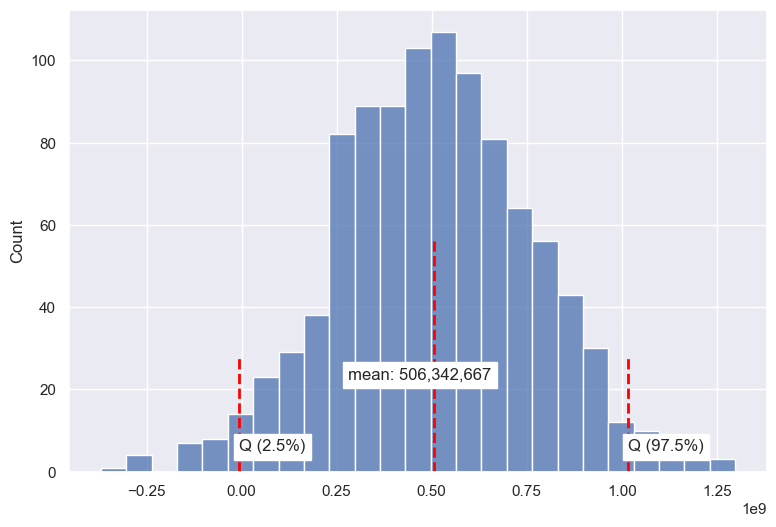

In [26]:
results.append(reg0_model.bootstrap())

### Регион 1

Средняя прибыль: 457,459,654
2.5%-квантиль:   57,447,116
97.5%-квантиль:  837,353,719


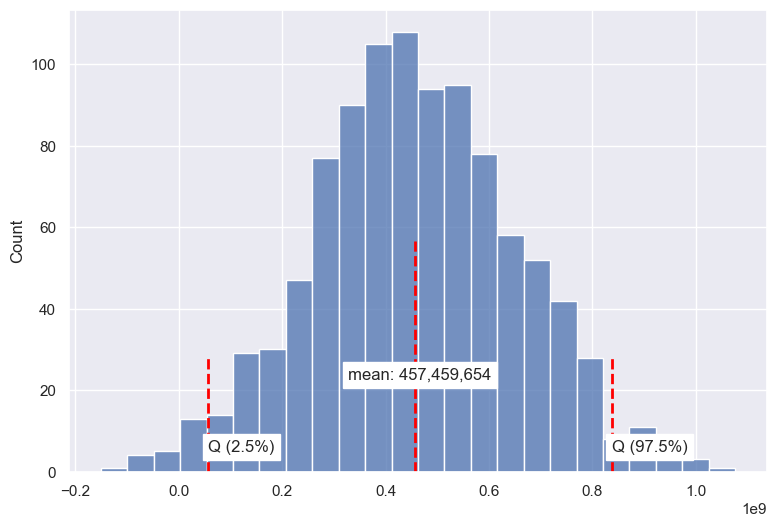

In [27]:
results.append(reg1_model.bootstrap())

### Регион 2

Средняя прибыль: 697,412,992
2.5%-квантиль:   143,107,512
97.5%-квантиль:  1,204,535,260


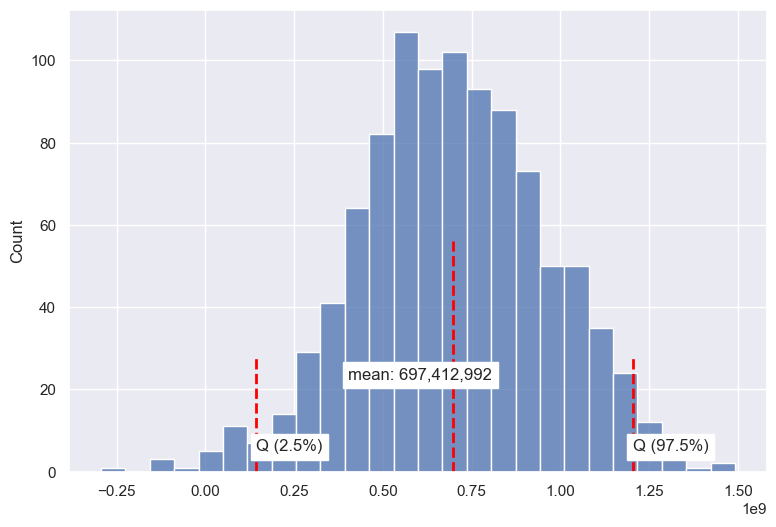

In [28]:
results.append(reg2_model.bootstrap())

In [29]:
# построим сводную таблицу для полученных результатов в миллионах
pd.DataFrame({
    'mean': [res.mean() / 1e+6 for res in results],
    '2.5%': [res.quantile(0.025) / 1e+6 for res in results],          # 2.5% квантиль
    'risk': [res[res < 0].size / res.size * 100 for res in results]   # вероятность, что разработка не окупится
    
}).rename_axis('region').style.format(precision=2)

,mean,2.5%,risk
region,,,
0,506.34,-5.77,2.80
1,457.46,57.45,1.00
2,697.41,143.11,0.60


<div class='conclusion'>
    Наиболее перспективным по среднему показателю прибыли и наименьшим рискам (здесь - это вероятность, что разработка не окупится) является регион 2. Выбираем его!
</div>

## Вывод

<div class='conclusion'>
    
- На основе полученных данных мы обучили три линейных модели для трех регионов. Ввиду сложных зависимостей целевой переменной от признаков для регионов 0 и 2, обученные модели обладают достаточно плохим показателем RMSE, около 37. В случае региона 1 модель обучилась гораздо лучше, для нее показатель RMSE составляет около 0.7. 
    
- Для того, чтобы разработка скважин была безубыточной, в среднем в 200 скважинах должно быть 111 тыс. баррелей запасов, что больше средних показателей по каждому из регионов.
    
- Бутстреп позволил оценить, что наиболее прибыльным и наименее рискованным будет разработка скважин в регионе 2.
</div>